Data Science Solutions with Python by Tshepo Chris Nokeri, Apress. 2021

# CHAPTER 4: CHAPTER 4 SURVIVAL ANALYSIS WITH PYSPARK AND LIFELINES

This introductory chapter debunks and executes survival analysis methods with chief
Python frameworks (i.e., Lifelines and PySpark). Initially, it explains the
underlying concept behind the Cox proportional hazards. Following that, it introduces the
accelerated failure time method.

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set("talk","ticks",font_scale=1,font="Calibri",color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
plt.rcParams["figure.dpi"] = 300
initial_data = pd.read_excel(r"C:\Users\i5 lenov\Downloads\survival_data.xlsx", index_col=[0])
initial_data.columns

C:\Users\i5 lenov\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\i5 lenov\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\i5 lenov\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


Index(['week', 'arrest', 'fin', 'age', 'race', 'wexp', 'mar', 'paro', 'prio'], dtype='object')

In [2]:
int(initial_data.shape[0]) * 0.8

345.6

In [3]:
lifeline_training_data = initial_data.loc[:346]
lifeline_test_data = initial_data.loc[346:]

# Lifeline in Action

In [4]:
from lifelines import CoxPHFitter
lifeline_cox_method = CoxPHFitter()
lifeline_cox_method.fit(lifeline_training_data, initial_data.columns[0], initial_data.columns[1])

<lifelines.CoxPHFitter: fitted with 347 total observations, 261 right-censored observations>

## Check Assumptions

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable 'age' failed the non-proportional test: p-value is 0.0010.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'wexp' failed the non-proportional test: p-value is 0.0006.

   Advice: with so few unique values (only 2), you can include `strata=['wexp', ...]` in the call in
`.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/lat

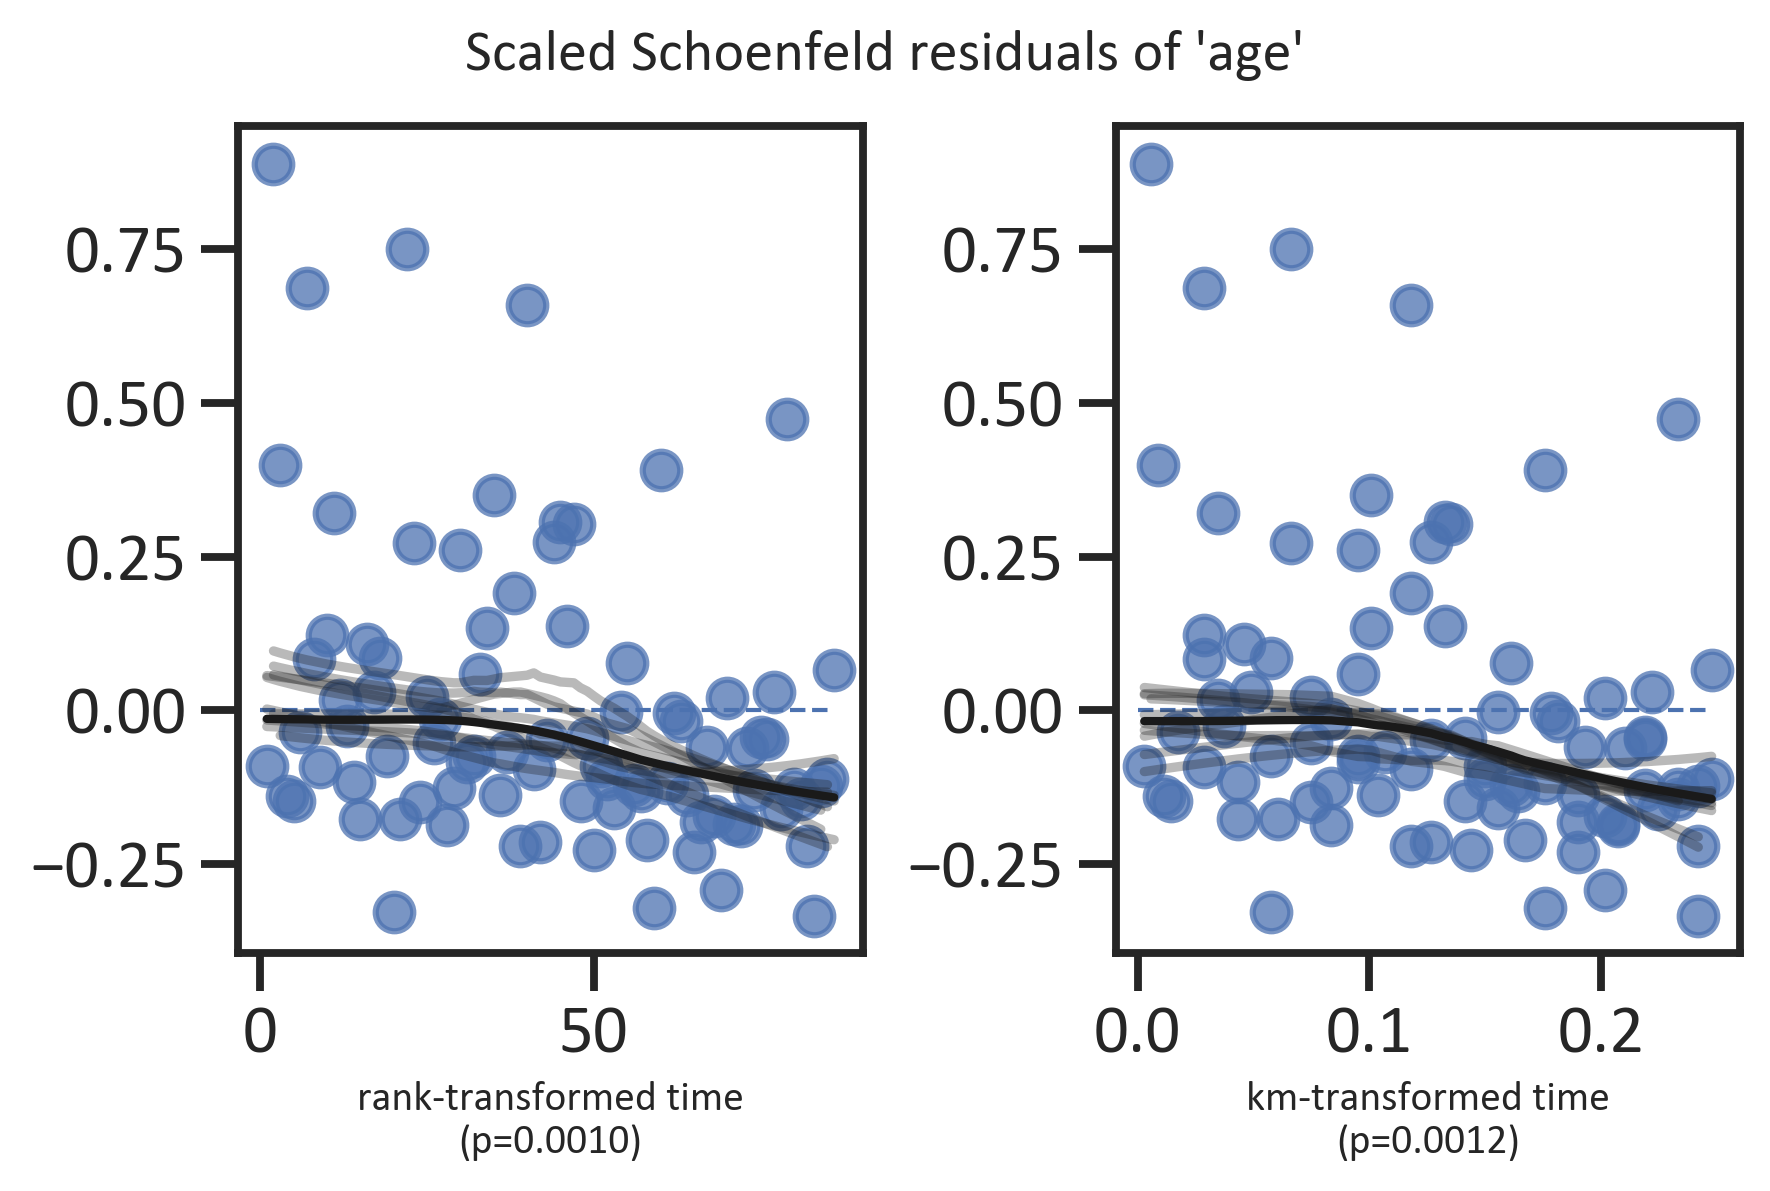

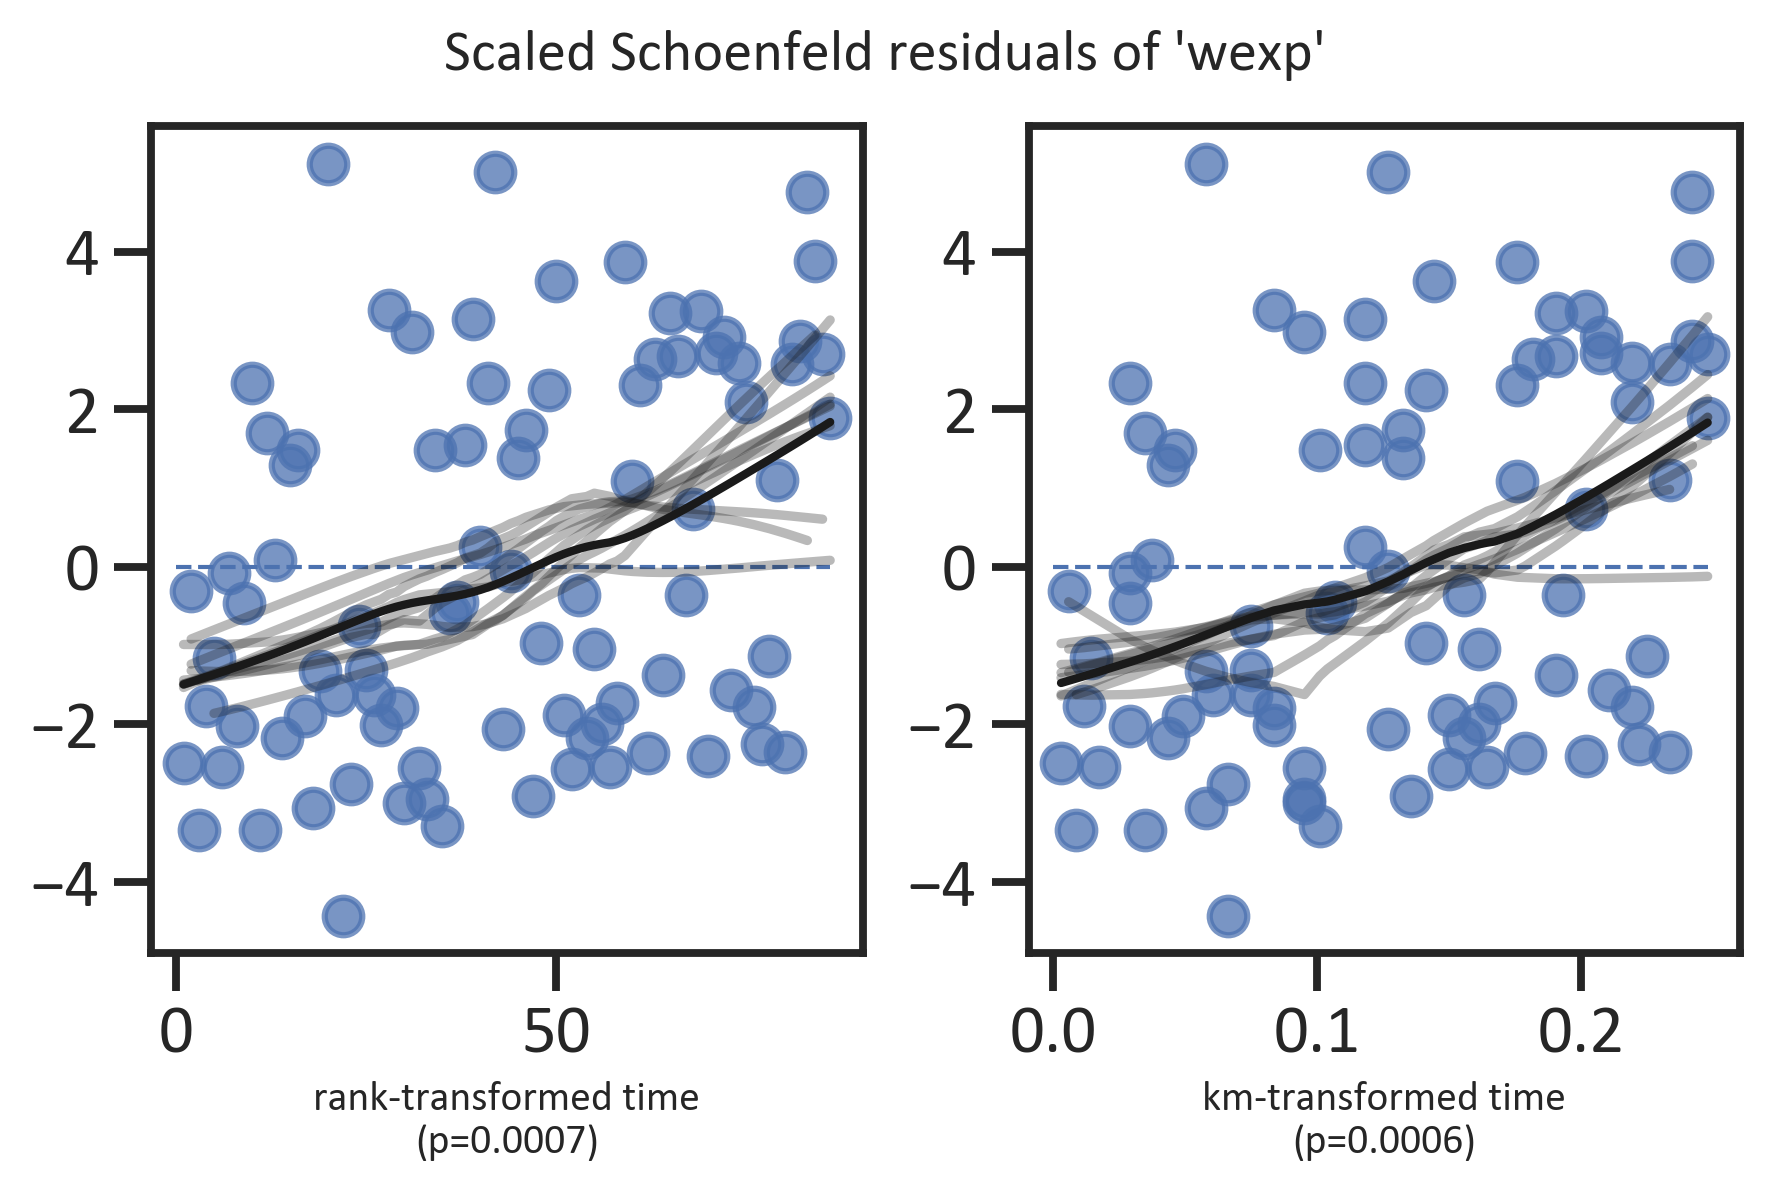

In [5]:
lifeline_cox_method_test_statistics_schoenfeld = lifeline_cox_method.check_assumptions(lifeline_training_data, show_plots=True)
lifeline_cox_method_test_statistics_schoenfeld

In [6]:
lifeline_cox_method_assessment_summary = lifeline_cox_method.print_summary()
lifeline_cox_method_assessment_summary

<AxesSubplot:xlabel='log(HR) (95% CI)'>

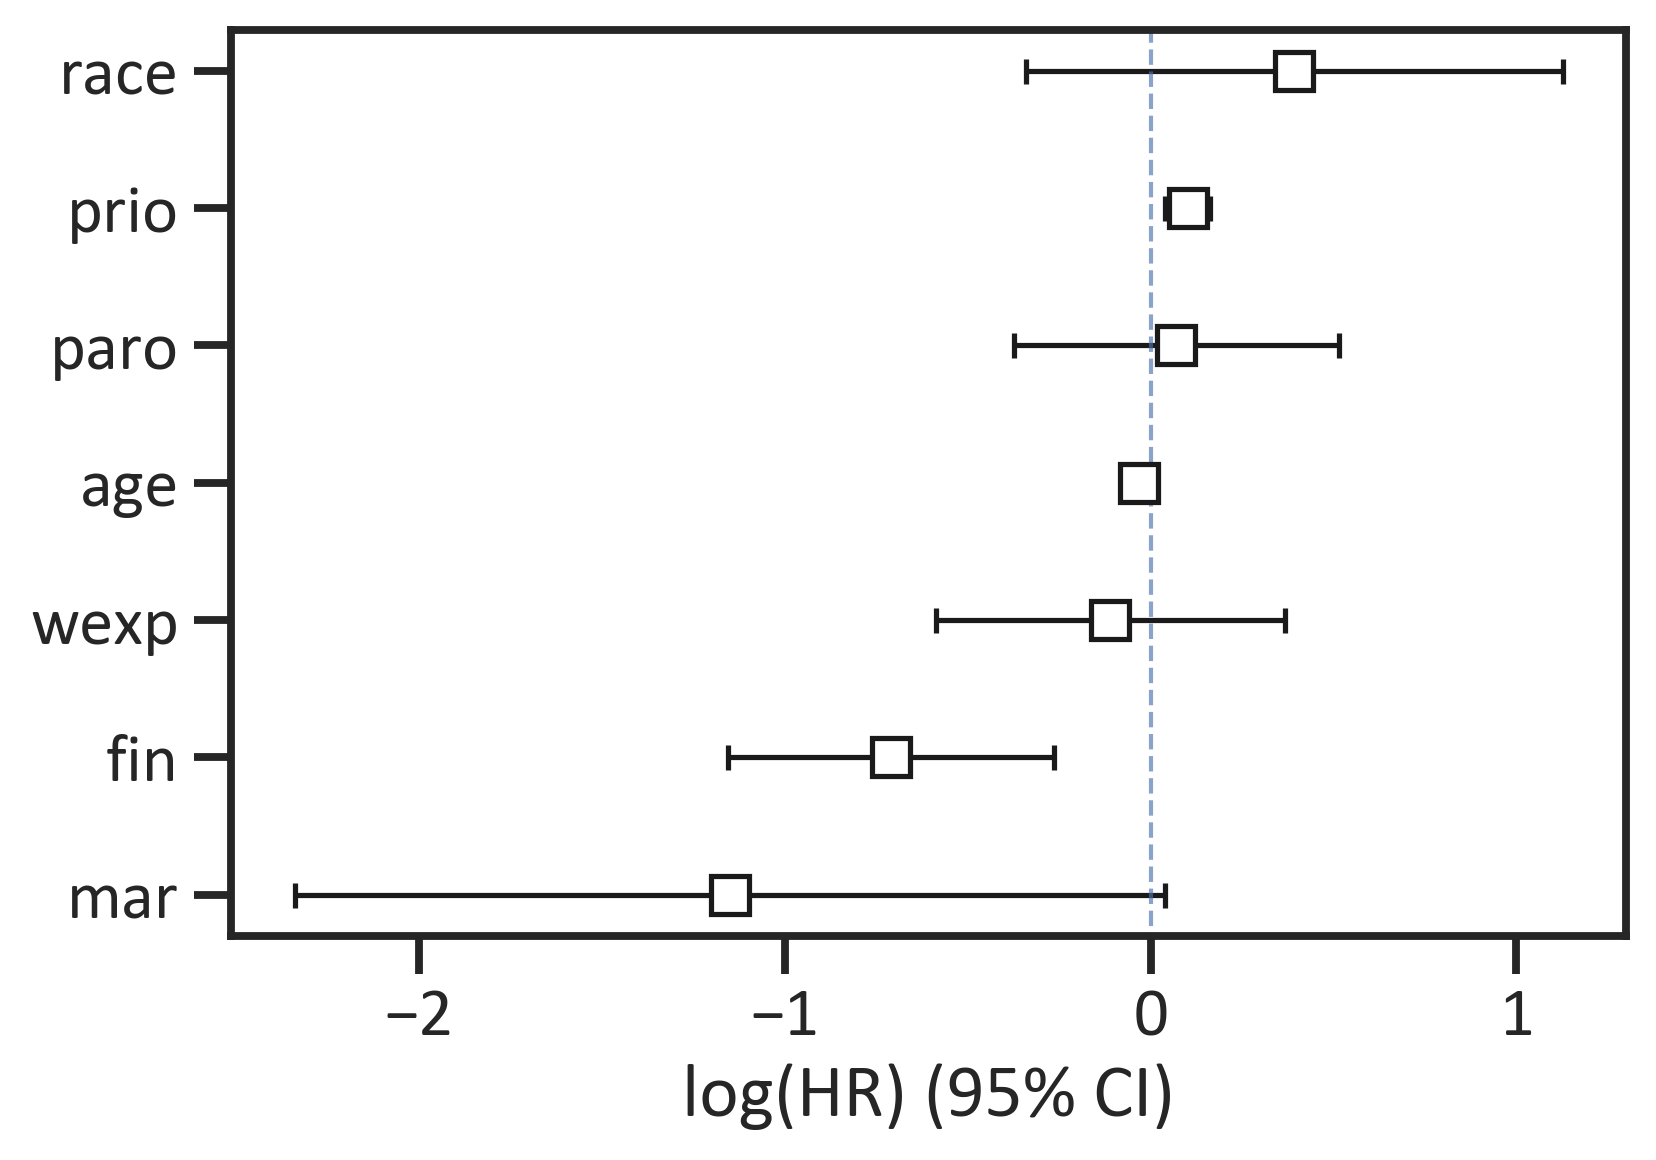

In [7]:
lifeline_cox_log_test_ci = lifeline_cox_method.plot()
lifeline_cox_log_test_ci

# Spark MLlib

In [8]:
import findspark as initiate_pyspark
initiate_pyspark.init("C:\Spark\spark-3.0.0-bin-hadoop2.7")

In [9]:
from pyspark import SparkConf
pyspark_configuration = SparkConf().setAppName("pyspark_aft_method").setMaster("local")

In [10]:
from pyspark import SparkContext
pyspark_context = SparkContext(conf=pyspark_configuration)

In [11]:
from pyspark.sql import SparkSession
pyspark_session = SparkSession(pyspark_context)

In [12]:
pyspark_initial_data = pyspark_session.createDataFrame(initial_data)

In [13]:
x_list = list(initial_data.iloc[::, 0:9].columns)
from pyspark.ml.feature import VectorAssembler
pyspark_data_columns = x_list
pyspark_vector_assembler = VectorAssembler(inputCols=pyspark_data_columns, outputCol="variables")
pyspark_data = pyspark_vector_assembler.transform(pyspark_initial_data)

In [14]:
from pyspark.ml.regression import AFTSurvivalRegression
pyspark_accelerated_failure_method = AFTSurvivalRegression(censorCol=pyspark_data.columns[1], labelCol=pyspark_data.columns[0],featuresCol="variables",)
pyspark_accelerated_failure_method_fitted = pyspark_accelerated_failure_method.fit(pyspark_data)

In [15]:
pyspark_yhat = pyspark_accelerated_failure_method_fitted.transform(pyspark_data).select(pyspark_data.columns[1],"prediction")
pyspark_yhat.show()

+------+------------------+
|arrest|        prediction|
+------+------------------+
|     1|18.883982665910125|
|     1| 16.88228128814963|
|     1|22.631360777172517|
|     0|373.13041474613107|
|     0| 377.2238319806288|
|     0| 375.8326538406928|
|     1|  20.9780526816987|
|     0| 374.6420738270714|
|     0| 379.7483494080467|
|     0| 376.1601473382181|
|     0| 377.1412349521787|
|     0| 373.7536844216336|
|     1| 36.36443059383637|
|     0|374.14261327949384|
|     1| 22.98494042401171|
|     1| 50.61463874375869|
|     1| 25.56399364288275|
|     0|379.61997114629696|
|     0| 384.3322960430372|
|     0|376.37634062210844|
+------+------------------+
only showing top 20 rows



In [16]:
pyspark_accelerated_failure_method_fitted.coefficients

DenseVector([0.0388, -1.7679, -0.0162, -0.0003, 0.0098, -0.0086, -0.0026, 0.0115, 0.0003])